# RAG Experimentation - RAG_CATEGORY

## Introduction
This notebook focuses on experimenting with RAG_CATEGORY Retrieval-Augmented Generation (RAG) method. The primary goal is to empirically evaluate its performance based on [TruERA RAG evaluation framework](https://truera.com/ai-quality-education/generative-ai-rags/what-is-the-rag-triad/):

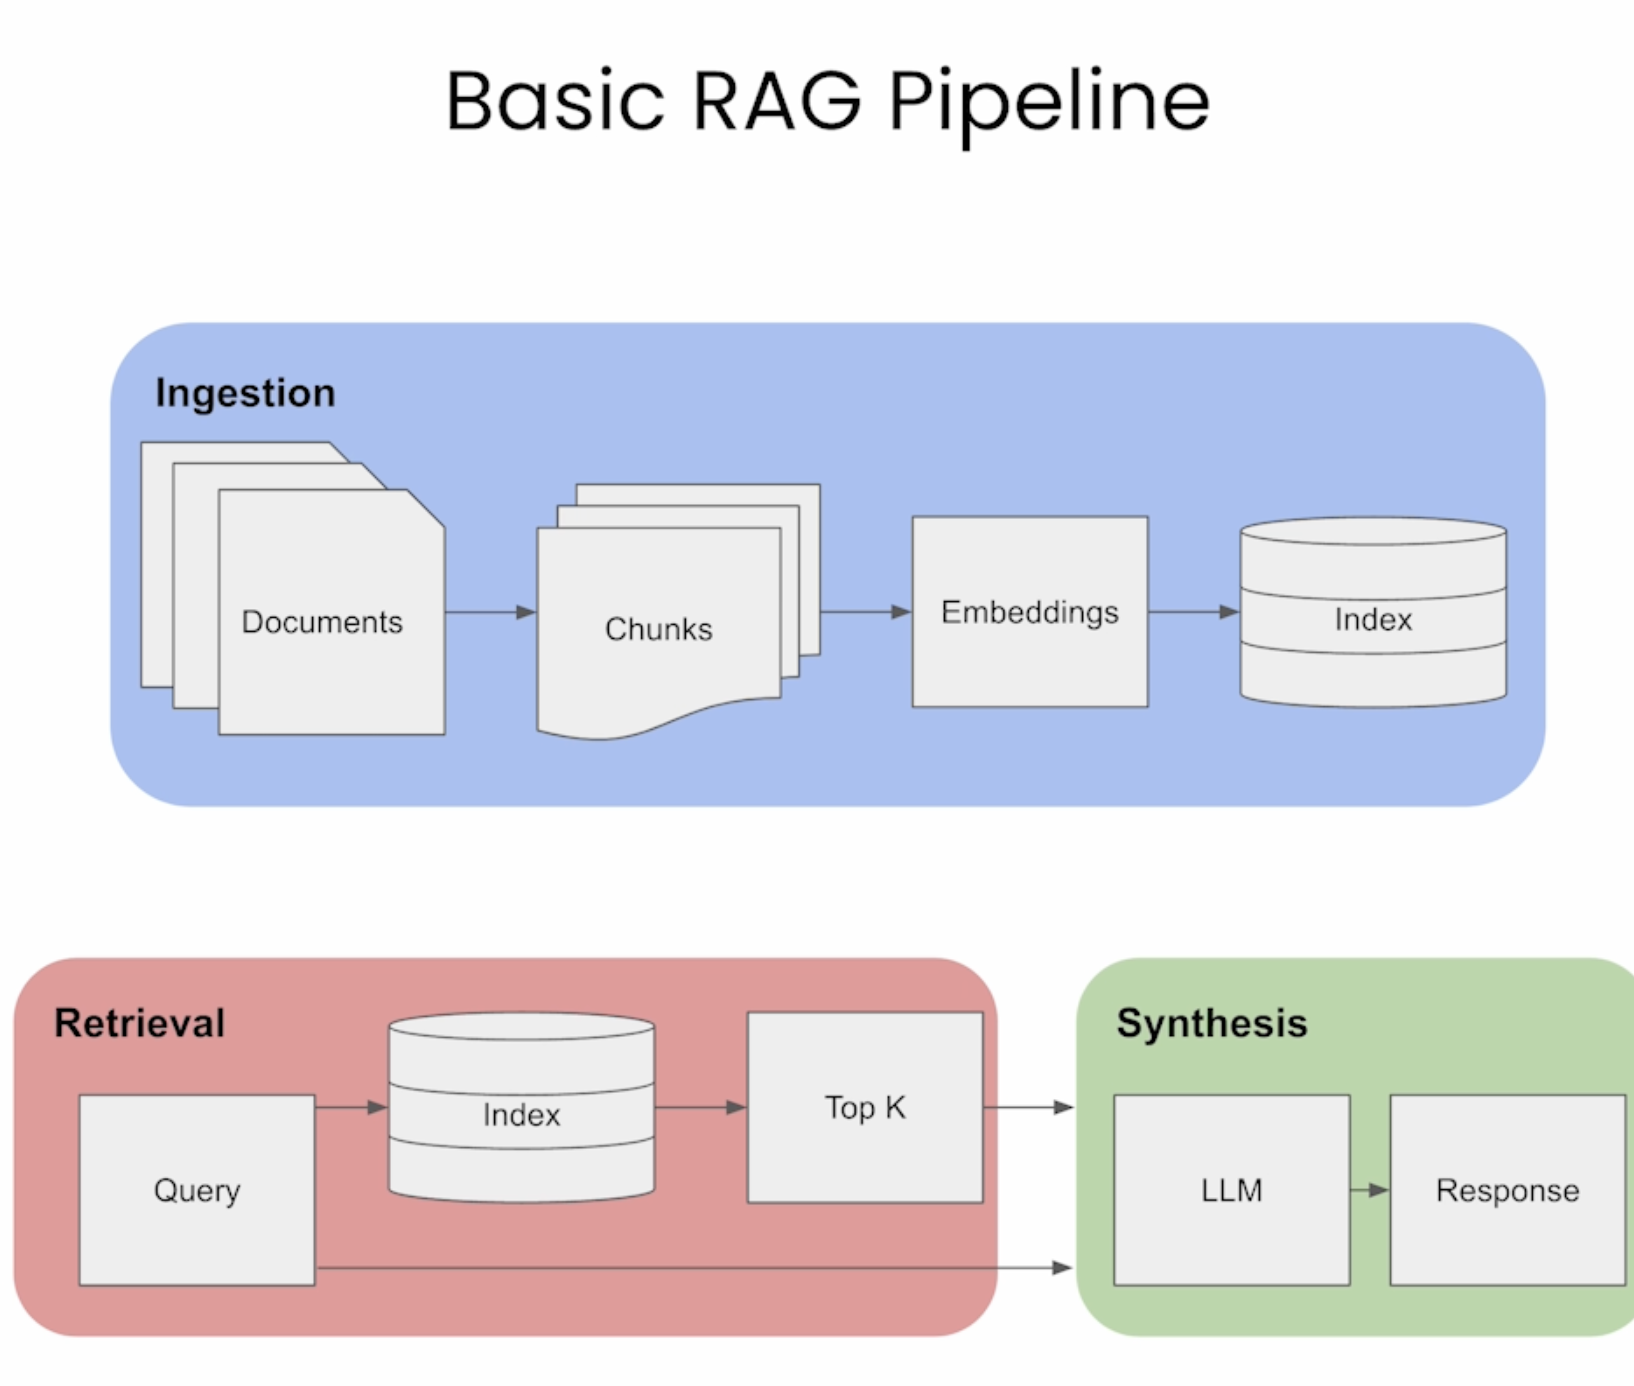


We adhere to the **conventional RAG pipeline** defined by the research community, which integrates retrieval systems with generative models. This structured approach ensures a comprehensive evaluation of the RAG_CATEGORY effectiveness in delivering accurate, context-aware outputs.Through this experimentation, we aim to identify its strengths and weaknesses in order to determine which RAG techniques is better to be used in our Specialist bot project.

## Ingestion

In [1]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

PDF_PATH="assets/pdf/fundamentals-data-engineering-chap1.pdf"
loader = PyPDFLoader(PDF_PATH)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=60)
chunks = text_splitter.split_documents(pages)

In [2]:
pages[0]

Document(metadata={'source': 'assets/pdf/fundamentals-data-engineering-chap1.pdf', 'page': 0}, page_content='978-1-098-10830-4\n[LSI]\nFundamentals of Data Engineering\nby Joe Reis and Matt Housley\nCopyright © 2022 Joseph Reis and Matthew Housley. All rights reserved.\nPrinted in the United States of America.\nPublished by O’Reilly Media, Inc., 1005 Gravenstein Highway North, Sebastopol, CA 95472.\nO’Reilly books may be purchased for educational, business, or sales promotional use. Online editions are\nalso available for most titles (http://oreilly.com). For more information, contact our corporate/institutional\nsales department: 800-998-9938 or corporate@oreilly.com.\nAcquisitions Editor: Jessica Haberman\nDevelopment Editor: Michele Cronin\nProduction Editor: Gregory Hyman\nCopyeditor: Sharon Wilkey\nProofreader: Amnet Systems, LLC\nIndexer: Judith McConville\nInterior Designer: David Futato\nCover Designer: Karen Montgomery\nIllustrator: Kate Dullea\nJuly 2022:  First Edition\nRevi

In [3]:
import json
def save_list_of_dicts_to_json(data: list, file_path: str):
    """
    Saves a list of dictionaries to a JSON file.
    
    Parameters:
    - data (list): List of dictionaries to save.
    - file_path (str): Path where the JSON file will be saved.
    """
    try:
       
        with open(file_path, 'w') as json_file:
            json.dump(data, json_file, indent=4)
        print(f"Data successfully saved to {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

listtest = [{"key1": 1}, {"key2": 2}]
save_list_of_dicts_to_json(listtest, "test.json")

Data successfully saved to test.json


In [4]:
chunks[0]

Document(metadata={'source': 'assets/pdf/fundamentals-data-engineering-chap1.pdf', 'page': 0}, page_content='978-1-098-10830-4\n[LSI]\nFundamentals of Data Engineering\nby Joe Reis and Matt Housley\nCopyright © 2022 Joseph Reis and Matthew Housley. All rights reserved.\nPrinted in the United States of America.\nPublished by O’Reilly Media, Inc., 1005 Gravenstein Highway North, Sebastopol, CA 95472.')

### Generate QA and ground of truth dataset

In [5]:
#toogle comment if you not generate qa dataset yet
# !python scripts/generate_questions.py

## Retrieval and Sinthesis

In [5]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.vectorstores import DocArrayInMemorySearch
from langchain.prompts import PromptTemplate
from IPython.display import display, Markdown
from langchain.embeddings import OpenAIEmbeddings
import dotenv
import os

dotenv.load_dotenv("../.env")
LLM_MODEL="gpt-4o-mini"
TEMPLATE = """Use the following pieces of context to answer the question at the end. 
If you don't know the answer, just say that you don't know, don't try to make up an answer. 
Use three sentences maximum. Keep the answer as concise as possible. 
Always say "thanks for asking!" at the end of the answer.
Question: {question}
Context:
{context}
Helpful Answer:"""

QA_CHAIN_PROMPT = PromptTemplate.from_template(TEMPLATE)
embeddings = OpenAIEmbeddings()
db = DocArrayInMemorySearch.from_documents(
    chunks, 
    embeddings
)
llm = ChatOpenAI(temperature = 0.0, model=LLM_MODEL)
retriever = db.as_retriever()
rag_chain = RetrievalQA.from_chain_type(
    llm=llm, 
    chain_type="stuff", 
    retriever=retriever, 
    verbose=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

/var/folders/92/nypxyrhd5jb8z0y5frdy8_dh0000gp/T/ipykernel_53095/721209719.py:22: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings()
/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/pydantic/_migration.py:283: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')
/var/folders/92/nypxyrhd5jb8z0y5frdy8_dh0000gp/T/ipykernel_53095/721209719.py:27: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :cla

In [6]:
response = rag_chain.invoke("what is Data Engineering ?")
display(Markdown(response["result"]))



> Entering new RetrievalQA chain...

> Finished chain.


Data engineering is the development, implementation, and maintenance of systems that transform raw data into high-quality, consistent information for analysis and machine learning. It involves processes that ensure data is accessible and usable for data scientists and analysts. Thanks for asking!

## Evalution

### Evaluation Methodology

To assess the RAG models, we utilize the **RAG TRIAD evaluation framework** from TRuERA, implemented via the **TruLens library**. This robust methodology allows for a thorough and detailed evaluation of model performance:

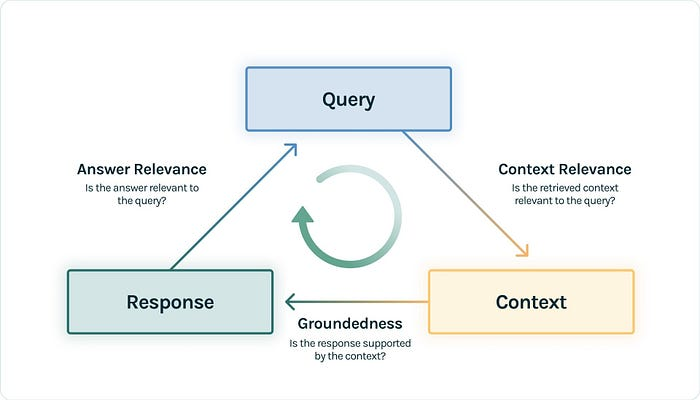


We're gonna use the following evaluations criteria include the following:

1. **Accuracy of Answers**  
   - Manually evaluated by a human.
   
2. **Context Relevance**  
   - Automatically generated metric based on LLM evaluation.

3. **Answer Relevance**  
   - Automatically generated metric based on LLM evaluation.

4. **Groundedness**  
   - Automatically generated metric based on LLM evaluation.

5. **Explainability and Traceability of Context Retrieval**  
   - Assessed through the TruLens dashboard and cross-validation between manual evaluations and automated metrics.

In [7]:
from trulens.apps.langchain import TruChain
from trulens.providers.openai import OpenAI
from trulens.feedback.v2.feedback import Groundedness
from trulens_eval import Tru
from trulens.core.feedback import Feedback
from trulens_eval import Select
from trulens_eval import OpenAI as fOpenAI
import numpy as np


/var/folders/92/nypxyrhd5jb8z0y5frdy8_dh0000gp/T/ipykernel_53095/1374296495.py:4: DeprecationWarning: The `trulens_eval` module is deprecated. See https://www.trulens.org/component_guides/other/trulens_eval_migration/ for instructions on migrating to `trulens.*` modules.
  from trulens_eval import Tru


In [8]:

provider = OpenAI(model_engine=LLM_MODEL)
groundedness_openai = Groundedness(groundedness_provider=provider)

context = TruChain.select_context(rag_chain)

f_context_relevance = (
    Feedback(provider.context_relevance_with_cot_reasons)
    .on_input()
    .on(context)  # Refers to context defined from `select_context`
    .aggregate(np.mean)
)

f_qa_relevance = Feedback(
    provider.relevance_with_cot_reasons,
    name="Answer Relevance"
).on_input_output()



f_groundedness = (
    Feedback(
        OpenAI(model_engine=LLM_MODEL).groundedness_measure_with_cot_reasons,
        name=f"Groundedness OpenAI {LLM_MODEL}",
    )
    .on_input()
    .on_output()
    .aggregate(np.mean)
)






🦑 Initialized with db url sqlite:///default.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of `TruSession` to prevent this.
✅ In context_relevance_with_cot_reasons, input question will be set to __record__.main_input or `Select.RecordInput` .
✅ In context_relevance_with_cot_reasons, input context will be set to __record__.app.retriever.invoke.rets[:].page_content .
✅ In Answer Relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Answer Relevance, input response will be set to __record__.main_output or `Select.RecordOutput` .
✅ In Groundedness OpenAI gpt-4o-mini, input source will be set to __record__.main_input or `Select.RecordInput` .
✅ In Groundedness OpenAI gpt-4o-mini, input statement will be set to __record__.main_output or `Select.RecordOutput` .


In [ ]:
import json


truchain = TruChain(
    rag_chain,
    app_name='Chain1_ChatApplication',
    feedbacks=[f_qa_relevance, f_context_relevance,f_groundedness]
)
tru = Tru()
tru.reset_database()



with open('assets/json/QA_groundTruth.json', 'r') as file:
    questions_answers = json.load(file)


with truchain as recording:
    for qa in questions_answers:
        rag_chain(qa["question"])

feedback = tru.get_records_and_feedback(app_ids=["Chain1_ChatApplication"])
tru.run_dashboard()

Object (of type list is a sequence containing more than one dictionary. Lookup by item or attribute `rets` is ambiguous. Use a lookup by index(es) or slice first to disambiguate.
Object (of type list is a sequence containing more than one dictionary. Lookup by item or attribute `rets` is ambiguous. Use a lookup by index(es) or slice first to disambiguate.
Object (of type list is a sequence containing more than one dictionary. Lookup by item or attribute `rets` is ambiguous. Use a lookup by index(es) or slice first to disambiguate.
Updating app_name and app_version in apps table: 0it [00:00, ?it/s]
Updating app_id in records table: 0it [00:00, ?it/s]
Updating app_json in apps table: 0it [00:00, ?it/s]




> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...


/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



> Finished chain.


> Entering new RetrievalQA chain...


/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



> Finished chain.


> Entering new RetrievalQA chain...


/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



> Finished chain.


> Entering new RetrievalQA chain...


/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering

/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



> Finished chain.


> Entering new RetrievalQA chain...


/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering

/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...


/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...


/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...


/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering

/var/folders/92/nypxyrhd5jb8z0y5frdy8_dh0000gp/T/ipykernel_53095/1095961569.py:23: DeprecationWarning: Method `run_dashboard` has been renamed or moved to `trulens.dashboard.run.run_dashboard`.

  tru.run_dashboard()


Accordion(children=(VBox(children=(VBox(children=(Label(value='STDOUT'), Output())), VBox(children=(Label(valu…

Dashboard started at http://192.168.1.26:51225 .


<Popen: returncode: None args: ['streamlit', 'run', '--server.headless=True'...>

Exception in thread manage_pending_feedback_results_thread(app_name=Chain1_ChatApplication, app_version=base):
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/opt/homebrew/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/trulens/core/utils/python.py", line 621, in _future_target_wrapper
    return func(*args, **kwargs)
  File "/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/trulens/core/app.py", line 501, in _manage_pending_feedback_results
    r

## Conclusions
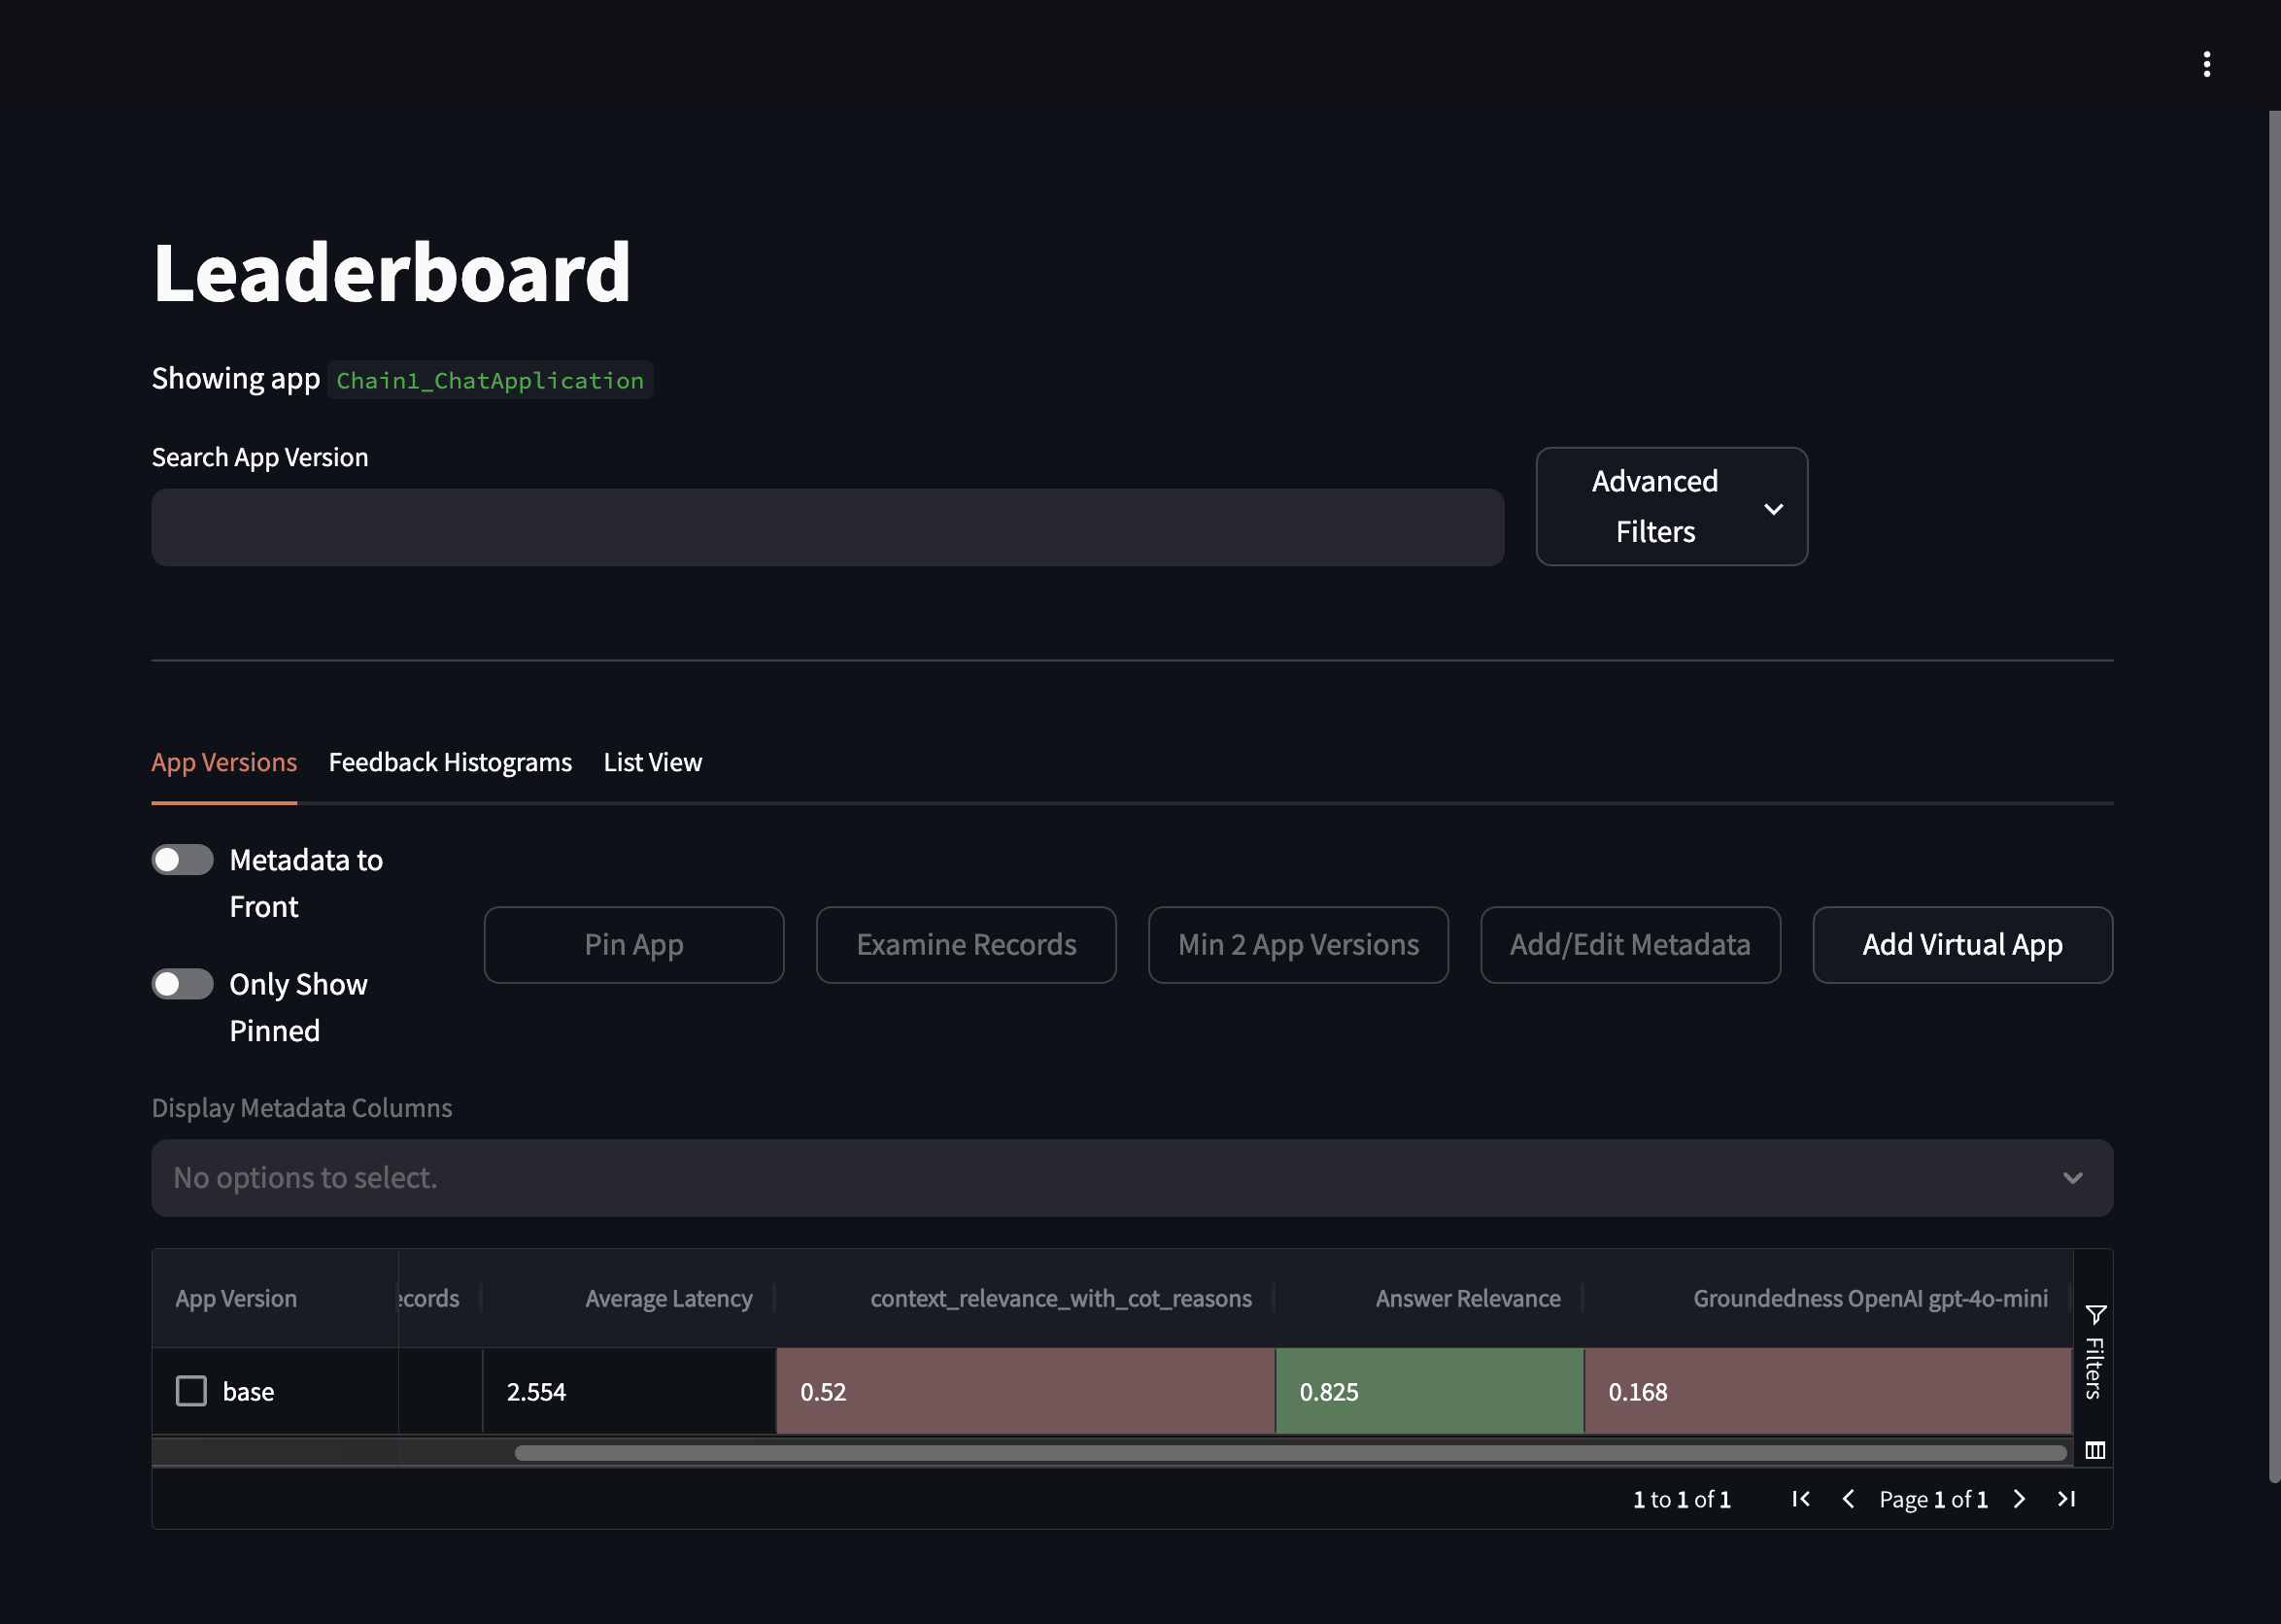

It seems, the llm is using more its own prior knowledge than the provided context  from RAG